In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from datetime import datetime, date
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from math import sqrt
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle

In [3]:
FILES_DIR = './files/'
events = pd.read_csv(FILES_DIR + 'sampled_events.csv')
product = pd.read_csv(FILES_DIR + 'sampled_products.csv')
users = pd.read_csv(FILES_DIR + 'sampled_users.csv')

In [6]:
drop_events = events.copy()
drop_events['mobile_brand_name'].fillna('un_brand_name', inplace=True)
drop_events.drop('mobile_marketing_name', axis=1, inplace=True)
drop_events.drop('mobile_model_name', axis=1, inplace=True)
drop_events.drop('operating_system_version', axis=1, inplace=True)
drop_events['rating'] = drop_events['event_name']
re_name = {'rating' : {'click_item':1, 'like_item':2, 'add_to_cart':3, 'purchase_success':4}}
drop_events = drop_events.replace(re_name)
drop_events.dropna(axis=0, inplace=True)
df_events = drop_events.copy()

today = pd.Timestamp.now().floor('D')
users['birth_date'] = pd.to_datetime(users['birth_date'], errors='coerce')
users = users[~pd.isnull(users['birth_date'])] # remove rows with missing birth date
users['age'] = ((today - users['birth_date']).dt.days / 365.25).astype(int)

def age_category(age):
    age = (age // 10) * 10
    return age

users['age'] = users.age.apply(age_category)

total_df = pd.merge(df_events, users)
total_df = pd.merge(total_df, product)
total_df['birth_date'].fillna('un_birth_date', inplace=True)
total_df['gender'].fillna('un_gender', inplace=True)
total_df = total_df.dropna()
total_df.isnull().sum()

session_id           0
event_timestamp      0
event_name           0
user_no              0
item_no              0
device_type          0
mobile_brand_name    0
country              0
region               0
platform             0
rating               0
birth_date           0
gender               0
age                  0
item_name            0
image_name           0
price                0
category1_code       0
category1_name       0
category2_code       0
category2_name       0
category3_code       0
category3_name       0
brand_no             0
brand_name           0
dtype: int64

In [ ]:
user_no_group = pd.DataFrame({'count': total_df.groupby(['session_id', 'user_no', 'item_no', 'gender', 'platform']).size()})
user_no_group = user_no_group.reset_index()

user_no_group2 = total_df.groupby('user_no')['rating'].mean().reset_index()

user_no_group3 = pd.merge(user_no_group, user_no_group2, on='user_no', how='inner')

user_no_group3 = user_no_group3

user_no_group_df = user_no_group3.sort_values(by='rating', ascending=False)

# user_no_group_df = user_no_group_df.drop_duplicates(subset='user_no', keep='first')

user_no_group_df = user_no_group_df[user_no_group_df['count'] == 1]

user_no_group_df

In [24]:
user_no_group_df = user_no_group_df.sample(frac=0.003, random_state=42)
user_no_group_df.shape

(12245, 7)

In [25]:
train_df, test_df = train_test_split(user_no_group_df, test_size=0.25, random_state=42)

print(train_df.shape)
print(test_df.shape)

(9183, 7)
(3062, 7)


In [31]:
session_id_group = pd.DataFrame({'count': user_no_group_df.groupby(['session_id', 'item_no']).size()})
session_id_group = session_id_group.reset_index()


user_no_group = pd.DataFrame({'count': user_no_group_df.groupby(['user_no', 'item_no']).size()})
user_no_group = user_no_group.reset_index()


gender_group = pd.DataFrame({'count': user_no_group_df.groupby(['gender', 'item_no']).size()})
gender_group = gender_group.reset_index()


platform_group = pd.DataFrame({'count': user_no_group_df.groupby(['platform', 'item_no']).size()})
platform_group = platform_group.reset_index()

In [46]:
session_id = [(list(set(x['item_no'].values))[0], '/'.join(x['session_id'].values)) for index, x in session_id_group.groupby('item_no')]
session_id_df = pd.DataFrame(data=session_id, columns=['item_no', 'session_id'])
session_id_df = session_id_df.set_index('item_no')


user_no = [(list(set(x['item_no'].values))[0], '/'.join(x['user_no'].values)) for index, x in user_no_group.groupby('item_no')]
user_no_df = pd.DataFrame(data=user_no, columns=['item_no', 'user_no'])
user_no_df = user_no_df.set_index('item_no')


gender = [(list(set(x['item_no'].values))[0], ','.join(x['gender'].values)) for index, x in gender_group.groupby('item_no')]
gender_df = pd.DataFrame(data=gender, columns=['item_no', 'gender'])
gender_df = gender_df.set_index('item_no')


platform = [(list(set(x['item_no'].values))[0], ','.join(x['platform'].values)) for index, x in platform_group.groupby('item_no')]
platform_df = pd.DataFrame(data=platform, columns=['item_no', 'platform'])
platform_df = platform_df.set_index('item_no')



total = pd.merge(session_id_df, user_no_df, on='item_no', how='inner')
total = pd.merge(total, gender_df, on='item_no', how='inner')
total = pd.merge(total, platform_df, on='item_no', how='inner')


print(total.shape)
print(total.head())

(9812, 4)
                                                                 session_id  \
item_no                                                                       
++X9xLHmeri+TUNYE0MktQ==                   e3d0000e4615fd856b45d9ebe2ee2b82   
++lfyxhDEeD3WKCR1QUomA==                   e96ef77141ab020fdb787ecdf120c294   
++smNa0pilAuwpRfS415uw==  0523536e957e3a4b50d93d010bffac69/29fa84cf87a19...   
+/5Zxwk4MFRzcScRcxf3Qw==                   6b23dde42e99187c0d9db2dcbe858529   
+/V7q1tjZsY+9xLibrenXA==                   a058ba42dbff499d7d1a6509ac05cfee   

                                                                    user_no  \
item_no                                                                       
++X9xLHmeri+TUNYE0MktQ==                           OiudMKh+l27lZlibNIUblg==   
++lfyxhDEeD3WKCR1QUomA==                           Ck4UCZcCRreagqou1LY8zg==   
++smNa0pilAuwpRfS415uw==  6HfHF7jgYi+EPsCrfafL+A==/6rsu3hO5wwFl8VXX+U+uZ...   
+/5Zxwk4MFRzcScRcxf3Qw==                 

In [52]:
dummy_session_id = total['session_id'].str.get_dummies(sep=',')

dummy_user_no = total['user_no'].str.get_dummies(sep=',')

dummy_gender = total['gender'].str.get_dummies(sep=',')

dummy_platform = total['platform'].str.get_dummies(sep=',')

,00005d011db80a956aab176cc94d1d37,0003f6dbeb4660decee100b2308f91ab,000df2a7f1dbfc5ed7b8746b3036f465/fe70e88fb2ba01d0c237acb806a804c9,0013ca55d30af45ec99661995e46d568,0013de104c1d7e9f8b799c0a9699b737,001881fb1798dd761af2ea2e92380c9f,0019118eb9a9373a7478f1034b235b9c,001a6c49dc0499fe53c41c6f91d90031/a9b1b1d43920019f9907997ca11db64c/ca1efca7655a478a4729bce29b091c8b,001ed0c8457cd45d0fd8fcd0c2ba40d0/daf9c8241be78840ac136eacbd1fe94c/f87b78439e74f3b7eb74699470d64de8,001f2e5c888ae213605141273b18ada2/a3f7b3dafd6c90fc6d5372432137ff67,...,ff86e576f41014bc6083cd55fbd5dfc6,ff8c2b76a65db532672c4588c0508ca0,ff8c98954c73e327c9173da1c156ca9c,ffa89b0fcdc479035a5c17b25b050a0c,ffb478ada32643f8427dc91339a97f26,ffb9f45bdf2564b9193867227f314626,ffd4a2bce01c12378a19a5127068d4c1,ffe84865992a64f374f775fe78d8c486,ffeee7c07545e9807a61b5c2ee09f58f,fffa949aa6d2b398d975e8b36a9676b9
item_no,,,,,,,,,,,,,,,,,,,,,
++X9xLHmeri+TUNYE0MktQ==,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
++lfyxhDEeD3WKCR1QUomA==,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
++smNa0pilAuwpRfS415uw==,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
+/5Zxwk4MFRzcScRcxf3Qw==,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
+/V7q1tjZsY+9xLibrenXA==,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zwxtMJFlL05KFNxR1p9K6A==,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zx7Zu3p4xlRjro1DcJDysw==,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zxwuuaGacBZx4rEN2lrzjQ==,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
X_train = pd.concat([pd.get_dummies(train_df['item_no'], prefix='item_no'),
           train_df['item_no'].apply(lambda x: dummy_session_id.loc[x]),
           train_df['item_no'].apply(lambda x: dummy_user_no.loc[x]),
           train_df['item_no'].apply(lambda x: dummy_gender.loc[x]),
           train_df['item_no'].apply(lambda x: dummy_platform.loc[x])], axis=1)

In [56]:
y_train = train_df['rating']
print(X_train.shape)
print(y_train.shape)

(9183, 26436)
(9183,)


In [58]:
import scipy
X_train_sparse = scipy.sparse.csr_matrix(X_train.values)

In [59]:
def log_loss(pred, y):
    return np.log(np.exp(-pred * y) + 1.0)


# Update gradients
def sgd(X, y, n_samples, n_features,
                w0, w, v, n_factors, learning_rate, reg_w, reg_v):
    data = X.data
    indptr = X.indptr
    indices = X.indices
    loss = 0.0

    for i in range(n_samples):
        pred, summed = predict(X, w0, w, v, n_factors, i)
        
        # calculate loss and its gradient
        loss += log_loss(pred, y[i])
        loss_gradient = -y[i] / (np.exp(y[i] * pred) + 1.0)
    
        # update bias/intercept term
        w0 -= learning_rate * loss_gradient

        # update weight
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            w[feature] -= learning_rate * (loss_gradient * data[index] + 2 * reg_w * w[feature])

        # update factor
        for factor in range(n_factors):
            for index in range(indptr[i], indptr[i + 1]):
                feature = indices[index]
                term = summed[factor] - v[factor, feature] * data[index]
                v_gradient = loss_gradient * data[index] * term
                v[factor, feature] -= learning_rate * (v_gradient + 2 * reg_v * v[factor, feature])
    
    loss /= n_samples
    return loss




def predict(X, w0, w, v, n_factors, i):
    data = X.data
    indptr = X.indptr
    indices = X.indices
    """predicting a single instance"""
    summed = np.zeros(n_factors)
    summed_squared = np.zeros(n_factors)

    # linear output w * x
    pred = w0
    for index in range(indptr[i], indptr[i + 1]):
        feature = indices[index]
        pred += w[feature] * data[index]

    # factor output
    for factor in range(n_factors):
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            term = v[factor, feature] * data[index]
            summed[factor] += term
            summed_squared[factor] += term * term

        pred += 0.5 * (summed[factor] * summed[factor] - summed_squared[factor])

    # gradient update할 때, summed는 독립이므로 re-use 가능
    return pred, summed




# Train Factorization Machine
# X -> sparse csr_matrix, y -> label
def fit(X, y, config):
    epochs = config['num_epochs']
    num_factors = config['num_factors']
    learning_rate = config['learning_rate']
    reg_weights = config['reg_weights']
    reg_features = config['reg_features']

    num_samples, num_features = X.shape
    weights = np.zeros(num_features) # -> w
    global_bias = 0.0 # -> w0
    
    # latent factors for all features -> v
    feature_factors = np.random.normal(size = (num_factors, num_features))

    epoch_loss = []
    for epoch in range(epochs):
        loss = sgd(X, y, num_samples, num_features,
                            global_bias, weights,
                            feature_factors, num_factors,
                            learning_rate, reg_weights, reg_features)
        print(f'[epoch: {epoch+1}], loss: {loss}')

        epoch_loss.append(loss)
      
    return epoch_loss


In [60]:
config = {
    "num_epochs": 10,
    "num_factors": 10,
    "learning_rate": 0.1,
    "reg_weights": 0.01,
    "reg_features": 0.01
}

In [61]:
epoch_loss = fit(X_train_sparse, y_train.values, config)

[epoch: 1], loss: 0.04880037784672979
[epoch: 2], loss: 0.022497656400306553
[epoch: 3], loss: 0.016950128307345946
[epoch: 4], loss: 0.01488638619691585
[epoch: 5], loss: 0.011965649054027127
[epoch: 6], loss: 0.011136019047257247
[epoch: 7], loss: 0.010739637394082565
[epoch: 8], loss: 0.009401053114960853
[epoch: 9], loss: 0.009152281367798982
[epoch: 10], loss: 0.008852074512341634


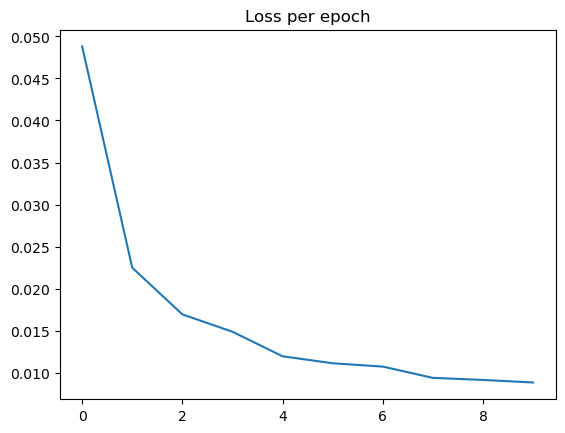

In [62]:
plt.plot(epoch_loss)
plt.title('Loss per epoch')
plt.show()